## TARGET AND HISTORY PATH VISUALISATION

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter
from prettytable import PrettyTable

#l5kit imports  
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from l5kit.data import PERCEPTION_LABELS
from scipy import stats

In [2]:
np.random.seed(1004)

### First, let's configure where our data lives!
The data is expected to live in a folder that can be configured using the `L5KIT_DATA_FOLDER` env variable. You data folder is expected to contain subfolders for the aerial and semantic maps as well as the scenes (`.zarr` files). 
In this example, the env variable is set to the local data folder. You should make sure the path points to the correct location for you.

We built our code to work with a human-readable `yaml` config. This config file holds much useful information, however, we will only focus on a few functionalities concerning loading and visualization here.

In [3]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "lyft-motion-prediction-autonomous-vehicles/"
dm = LocalDataManager(None)

In [4]:
cfg = {
    'format_version': 4,
    'model_params': {
        'model_architecture': 'resnet50',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1
    },
    
    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5,
        'disable_traffic_light_faces': False
    },
    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 12,
        'shuffle': False,
        'num_workers': 0
    },

    'sample_data_loader': {
        'key': 'scenes/sample.zarr',
        'batch_size': 12,
        'shuffle': False,
        'num_workers': 4
    }

}

## Load the data

The same config file is also used to load the data. Every split in the data has its own section, and multiple datasets can be used (as a whole or sliced). In this short example we will only use the first dataset from the `sample` set. You can change this by configuring the 'train_data_loader' variable in the config.

You may also have noticed that we're building a `LocalDataManager` object. This will resolve relative paths from the config using the `L5KIT_DATA_FOLDER` env variable we have just set.

In [5]:
%%time
rasterizer = build_rasterizer(cfg, dm)

CPU times: user 4.25 s, sys: 18.9 ms, total: 4.27 s
Wall time: 4.32 s


In [6]:
%%time
sample_zarr = ChunkedDataset(dm.require(cfg["sample_data_loader"]["key"])).open()

CPU times: user 2.85 ms, sys: 3.86 ms, total: 6.71 ms
Wall time: 15.3 ms


In [7]:
%%time
sample_AgentDataset = AgentDataset(cfg, sample_zarr, rasterizer)

CPU times: user 49.2 ms, sys: 8.3 ms, total: 57.5 ms
Wall time: 107 ms


In [8]:
print(sample_AgentDataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [9]:
print('Agents shape : ', sample_zarr.agents.shape)
print('Frames shape : ', sample_zarr.frames.shape)
print('Scense shape : ', sample_zarr.scenes.shape)

Agents shape :  (1893736,)
Frames shape :  (24838,)
Scense shape :  (100,)


In [10]:
len(sample_AgentDataset)

111634

In [11]:
temp = sample_AgentDataset[20]
temp.keys()

dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])

In [12]:
SAMPLES_TO_PLOT = 50

In [13]:
sampled_indices = np.random.randint(0, len(sample_AgentDataset), (SAMPLES_TO_PLOT,))

In [14]:
def plot_history_target_pos(ax, data):
    #ax.plot(data['history_positions'][:,0], data['history_positions'][:,1], 'b')
    ax.plot(data['target_positions'][:,0], data['target_positions'][:,1])

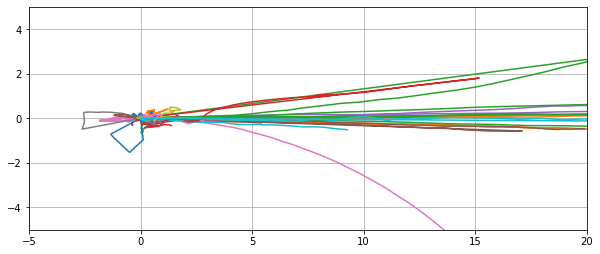

In [15]:
fig, ax = plt.subplots(figsize = (10,10)) #1,1,
ax.grid(True)
ax.set_aspect('equal', 'box')
ax.set_xlim([-5, 20])
ax.set_ylim([-5, 5])
for i in range(SAMPLES_TO_PLOT):
    plot_history_target_pos(ax, sample_AgentDataset[sampled_indices[i]])

## Working with the raw data

`.zarr` files support most of the traditional numpy array operations. In the following cell we iterate over the frames to get a scatter plot of the AV locations:

In [16]:
a = sample_zarr.frames[0] #np.void type 
a.view() #one frame's data

(1572643684801892606, [ 0, 38], [0, 0], [  680.61975098, -2183.32763672,   288.5411377 ], [[ 0.54673314, -0.83729434,  0.00459086], [ 0.83528739,  0.54502565, -0.07240184], [ 0.05811952,  0.04341917,  0.997365  ]])

In [17]:
temp = a["ego_translation"]
print(temp.shape)

(3,)


In [18]:
coordinates = sample_zarr.frames["ego_translation"][:, 0:2]

In [19]:
coordinates.shape, len(sample_zarr.frames)

((24838, 2), 24838)

(-2500.0, 1600.0)

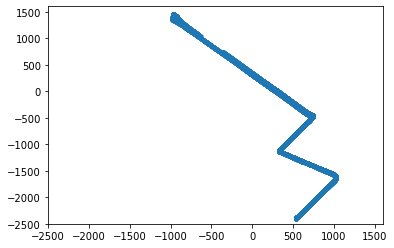

In [20]:
plt.scatter(coordinates[:, 0], coordinates[:, 1], marker='.')
axes = plt.gca()
axes.set_xlim([-2500, 1600])
axes.set_ylim([-2500, 1600])

Another easy thing to try is to get an idea of the agents types distribution. 

We can get all the agents `label_probabilities` and get the argmax for each raw. because `.zarr` files map to numpy array we can use all the traditional numpy operations and functions.

In [21]:
agents = sample_zarr.agents
probabilities = agents["label_probabilities"]
labels_indexes = np.argmax(probabilities, axis=1)
counts = []
for idx_label, label in enumerate(PERCEPTION_LABELS):
    counts.append(np.sum(labels_indexes == idx_label))
    
table = PrettyTable(field_names=["label", "counts"])
for count, label in zip(counts, PERCEPTION_LABELS):
    table.add_row([label, count])
print(table)

+------------------------------------+---------+
|               label                |  counts |
+------------------------------------+---------+
|      PERCEPTION_LABEL_NOT_SET      |    0    |
|      PERCEPTION_LABEL_UNKNOWN      | 1324481 |
|     PERCEPTION_LABEL_DONTCARE      |    0    |
|        PERCEPTION_LABEL_CAR        |  519385 |
|        PERCEPTION_LABEL_VAN        |    0    |
|       PERCEPTION_LABEL_TRAM        |    0    |
|        PERCEPTION_LABEL_BUS        |    0    |
|       PERCEPTION_LABEL_TRUCK       |    0    |
| PERCEPTION_LABEL_EMERGENCY_VEHICLE |    0    |
|   PERCEPTION_LABEL_OTHER_VEHICLE   |    0    |
|      PERCEPTION_LABEL_BICYCLE      |    0    |
|    PERCEPTION_LABEL_MOTORCYCLE     |    0    |
|      PERCEPTION_LABEL_CYCLIST      |   6688  |
|   PERCEPTION_LABEL_MOTORCYCLIST    |    0    |
|    PERCEPTION_LABEL_PEDESTRIAN     |  43182  |
|      PERCEPTION_LABEL_ANIMAL       |    0    |
|     AVRESEARCH_LABEL_DONTCARE      |    0    |
+-------------------

In [22]:
type(agents) #zarr.core.array
agents.view()

<zarr.core.Array '/agents' (1893736,) [('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))] read-only>

## Working with data abstraction

Even though it's absolutely fine to work with the raw data, we also provide classes that abstract data access to offer an easier way to generate inputs and targets.

### Core Objects
Along with the `rasterizer`, our toolkit contains other classes you may want to use while you build your solution. The `dataset` package, for example, already implements `PyTorch` ready datasets, so you can hit the ground running and start coding immediately.

### Dataset package
We will use two classes from the `dataset` package for this example. Both of them can be iterated and return multi-channel images from the rasterizer along with future trajectories offsets and other information.
- `EgoDataset`: this dataset iterates over the AV annotations
- `AgentDataset`: this dataset iterates over other agents annotations

Both support multi-threading (through PyTorch DataLoader) OOB.

In [23]:
sample_EgoDataset = EgoDataset(cfg, sample_zarr, rasterizer)

In [24]:
def print_Dataset_Info(Dataset):
    print('target_availabilities shape' , Dataset['target_availabilities'].shape)
    print('target position shape' , Dataset['target_positions'].shape)
    print('target yaw shape' , Dataset['target_yaws'].shape)
    print('history_positions shape' , Dataset['history_positions'].shape)
    print('history_yaws shape' , Dataset['history_yaws'].shape)
    print('history_availabilities shape' , Dataset['history_availabilities'].shape)
    print('image shape' , Dataset['image'].shape)    

In [25]:
def plot_Dataset_bev(data):
    temp = data['image'].transpose(1,2,0)
    print('Input shape :', {data['image'].shape}, ' Output shape : ', {temp.shape})
    plt.imshow(temp[:, :, -3:][::-1])

In [26]:
def plot_2d_points(points2D):
    plt.figure(figsize=(12, 8))
    plt.plot(points2D[:,0], points2D[:,1])
    plt.plot(points2D[:,0], points2D[:,1], 'go')
    plt.axis('equal')
    plt.grid(True)

In [27]:
def plot_agent_history(data):
    plt.figure(figsize=(100,100))
    for i in range(cfg['model_params']['history_num_frames'] + 1):
        plt.subplot(cfg['model_params']['history_num_frames'] + 1, 1, i+1)
        plt.imshow(data['image'][i])
    plt.show()

In [28]:
def plot_av_history(data):
    plt.figure(figsize=(100,100))
    for i in range(cfg['model_params']['history_num_frames'] + 1):
        plt.subplot(cfg['model_params']['history_num_frames'] + 1, 1, i+1)
        plt.imshow(data['image'][i + cfg['model_params']['history_num_frames'] + 1])
    plt.show()    

## Ego dataset functions and size

Let's get a sample from the dataset and use our `rasterizer` to get an RGB image we can plot. 

If we want to plot the ground truth trajectory, we can convert the dataset's `target_position` (displacements in meters in world coordinates) into pixel coordinates in the image space, and call our utility function `draw_trajectory` (note that you can use this function for the predicted trajectories, as well).

In [29]:
print(sample_EgoDataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [30]:
len(sample_EgoDataset)

24838

In [31]:
#type(sample_EgoDataset) # l5kit EgoDataset type
#sample_EgoDataset.cumulative_sizes

In [32]:
sample_EgoDataset.sample_function

functools.partial(<function generate_agent_sample at 0x7fa02bfb2a60>, render_context=<l5kit.rasterization.render_context.RenderContext object at 0x7fa02852b9e8>, history_num_frames=10, history_step_size=1, future_num_frames=50, future_step_size=1, filter_agents_threshold=0.5, rasterizer=<l5kit.rasterization.sem_box_rasterizer.SemBoxRasterizer object at 0x7fa02b5a6ac8>, perturbation=None)

In [33]:
data = sample_EgoDataset[50]

In [34]:
type(data) #dictionary
data.keys()

dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])

In [35]:
print_Dataset_Info(data)

target_availabilities shape (50,)
target position shape (50, 2)
target yaw shape (50, 1)
history_positions shape (11, 2)
history_yaws shape (11, 1)
history_availabilities shape (11,)
image shape (25, 224, 224)


In [36]:
data['world_to_image']

array([[ 1.09647763e+00,  1.67264366e+00,  2.83881073e+03],
       [-1.67264366e+00,  1.09647763e+00,  3.64489014e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

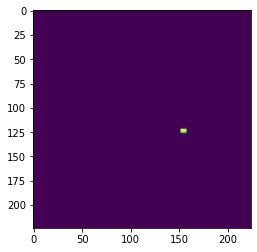

In [37]:
plt.imshow(data['image'][0])

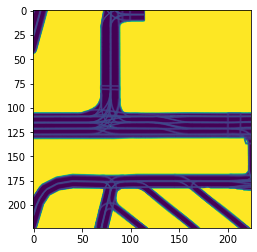

In [38]:
plt.imshow(data['image'][-1])

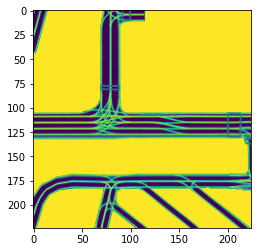

In [39]:
plt.imshow(data['image'][-2])

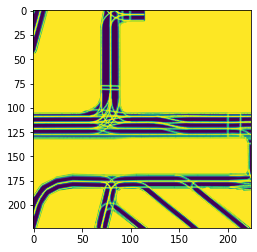

In [40]:
plt.imshow(data['image'][-3])

In [41]:
type(data['image'])

numpy.ndarray

Input shape : {(25, 224, 224)}  Output shape :  {(224, 224, 25)}


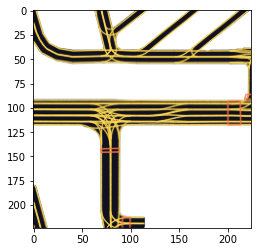

In [42]:
plot_Dataset_bev(data)

In [43]:
plt.imshow(temp[:, :, -3:])

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [ ]:
#stats.describe(data['image'][0])
np.min(data['image'][0]), np.max(data['image'][0])

In [ ]:
temp = data['world_to_image'] 

In [ ]:
plot_2d_points(data['target_positions'])

In [ ]:
target_pos_in_pixel = transform_points(data['target_positions'] + data['centroid'][:2], data['world_to_image'])

In [ ]:
target_pos_in_pixel.shape

In [ ]:
plot_2d_points(target_pos_in_pixel)

In [ ]:
plt.figure(figsize=(16, 12))
plt.imshow(data['image'][0])
plt.plot(target_pos_in_pixel[:,0], target_pos_in_pixel[:,1])
plt.plot(target_pos_in_pixel[:,0], target_pos_in_pixel[:,1], 'go')
plt.axis('equal')
plt.grid(True)

In [ ]:
data['image'][-3:].shape

In [ ]:
im = data["image"].transpose(1, 2, 0)
im = sample_EgoDataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
#draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, 1, data["target_yaws"])

plt.imshow(im[::-1])
plt.show()

## Agent Dataset functions

In [ ]:
print(sample_AgentDataset)

In [ ]:
len(sample_AgentDataset)

In [ ]:
agentData = sample_AgentDataset[50]

In [ ]:
agentData.keys()

In [ ]:
agentData['image'].shape

In [ ]:
plot_Dataset_bev(data)

In [ ]:
plt.imshow(data['image'][13])

In [ ]:
plot_agent_history(agentData)

In [ ]:
plot_av_history(agentData)

In [ ]:
print_Dataset_Info(agentData)

In [ ]:
plot_2d_points(agentData['target_positions'])

In [ ]:
len(sample_AgentDataset)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
sample_dataloader = DataLoader(sample_AgentDataset,
                              shuffle=cfg['sample_data_loader']["shuffle"],
                              batch_size=cfg['sample_data_loader']["batch_size"],
                              num_workers= cfg['sample_data_loader']["num_workers"])

In [ ]:
len(sample_dataloader)

In [ ]:
len(sample_AgentDataset) /  cfg['sample_data_loader']["batch_size"]

In [ ]:
111634 * 160